# Section 2: Homework Exercises


## Exercise: Cancer Rate Estimation

[Tsutakawa et al. (1985)](http://onlinelibrary.wiley.com/doi/10.1002/sim.4780040210/abstract) provides mortality data for stomach cancer among men aged 45-64 in several cities in Missouri. The file `cancer.csv` contains deaths $y_i$ and subjects at risk $n_i$ for 20 cities from this dataset.

In [2]:
import pandas as pd
import numpy as np

cancer = pd.read_csv('../data/cancer.csv')
cancer

,y,n
0,0,1083
1,0,855
2,2,3461
3,0,657
4,1,1208
5,1,1025
6,0,527
7,2,1668
8,1,583
9,3,582


If we use a simple binomial model, which assumes independent samples from a binomial distribution with probability of mortality $p$, we can use MLE to obtain an estimate of this probability.

$$\hat{p} = \frac{y}{n}$$

In [3]:
p_hat = cancer.y.sum() / cancer.n.sum()
p_hat

0.0009933126276616582

The binomial variance can be caclulated by:

$$\text{Var}(y) = np(1-p)$$

In [4]:
mle_var = (cancer.n * p_hat * (1-p_hat)).sum()
mle_var

70.92947480343602

However, if we compare this to the observed variance in $y$, things don't look good. 

In [5]:
np.var(cancer.y)

134.84750000000003

The data are *overdispersed* relative to what would be expected from a binomial model. As you might expect, it is unrealistic to assume the prevalence of cancer to be the same in all cities. Rather, a more realistic model might allow the probability to vary from place to place, according to any number of unmeasured risk factors. 

Create a hierarchical model that allows the cancer prevalence to vary. 

*Hint: a reasonable distribution for probabilities is the beta distribution. So, you would want to estimate the hyperparameters of the beta distribution to fit the hierarchical model.*

In [7]:
import pymc as pm
import arviz as az

with pm.Model() as cancer_model:

    alpha = pm.Exponential('alpha', 0.1)
    beta = pm.Exponential('beta', 0.1)

    p = pm.Beta('p', alpha, beta, shape=len(cancer))

    y = pm.Binomial('y', n=cancer.n, p=p, observed=cancer.y)

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

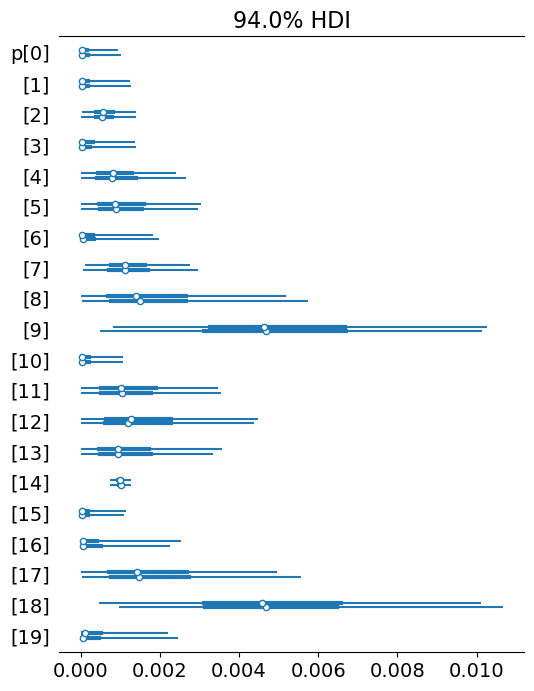

In [8]:
az.plot_forest(trace, var_names='p')

## Exercise: Effects of coaching on SAT scores

This example was taken from Gelman *et al.* (2013):

> A study was performed for the Educational Testing Service to analyze the effects of special coaching programs on test scores. Separate randomized experiments were performed to estimate the effects of coaching programs for the SAT-V (Scholastic Aptitude Test- Verbal) in each of eight high schools. The outcome variable in each study was the score on a special administration of the SAT-V, a standardized multiple choice test administered by the Educational Testing Service and used to help colleges make admissions decisions; the scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT examinations are designed to be resistant to short-term efforts directed specifically toward improving performance on the test; instead they are designed to reflect knowledge acquired and abilities developed over many years of education. Nevertheless, each of the eight schools in this study considered its short-term coaching program to be successful at increasing SAT scores. Also, there was no prior reason to believe that any of the eight programs was more effective than any other or that some were more similar in effect to each other than to any other.

You are given the estimated coaching effects (`d`) and their sampling variances (`s`). The estimates were obtained by independent experiments, with relatively large sample sizes (over thirty students in each school), so you can assume that they have approximately normal sampling distributions with known variances variances.

Here are the data:

In [9]:
J = 8
d = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
s = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])

Construct an appropriate model for estimating whether coaching effects are positive, using a **centered parameterization**, and then compare the diagnostics for this model to that from an **uncentered parameterization**.

Finally, perform goodness-of-fit diagnostics on the better model.

In [11]:
schools = np.array(
    [
        "Choate",
        "Deerfield",
        "Phillips Andover",
        "Phillips Exeter",
        "Hotchkiss",
        "Lawrenceville",
        "St. Paul's",
        "Mt. Hermon",
    ]
)

with pm.Model(coords={'school': schools}) as schools_centered:
    
    mu = pm.Normal("mu", 0, sigma=1e6)
    tau = pm.HalfCauchy("tau", 5)

    theta = pm.Normal("theta", mu, sigma=tau, dims='school')

    obs = pm.Normal("obs", theta, sigma=s, observed=d)

    trace_centered = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [12]:
with pm.Model(coords={'school': schools}) as schools_noncentered:
    
    mu = pm.Normal("mu", 0, sigma=1e6)
    tau = pm.HalfCauchy("tau", 5)

    z = pm.Normal("z", 0, sigma=1, dims='school')
    theta = mu + z * tau

    obs = pm.Normal("obs", theta, sigma=s, observed=d)

    trace_noncentered = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, tau, z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [13]:
with schools_centered:
    pm.compute_log_likelihood(trace_centered)

In [14]:
with schools_noncentered:
    pm.compute_log_likelihood(trace_noncentered)

In [18]:
az.compare({'centered': trace_centered, 'non-centered': trace_noncentered}, ic='loo')

/home/cfonnesbeck/miniforge3/envs/bayes_course/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/cfonnesbeck/miniforge3/envs/bayes_course/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
centered,0,-30.474043,0.800867,0.000000,1.000000e+00,1.100631,0.000000,False,log
non-centered,1,-30.840982,1.121962,0.366939,4.440892e-16,0.985388,0.198711,False,log


In [19]:
with schools_centered:
    pm.sample_posterior_predictive(trace_centered, extend_inferencedata=True)

Sampling: [obs]


<Axes: xlabel='obs / obs'>

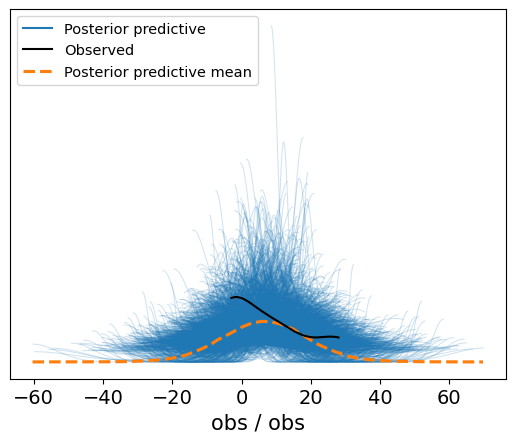

In [20]:
az.plot_ppc(trace_centered)